In [1]:
import kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

chip = kbench.Chip(6)

✅ BMC lib found. Running in control mode.


/tmp/ipykernel_93465/3895357141.py:7: DeprecationWarning: Chip is deprecated, use Arch instead
  chip = kbench.Chip(6)


In [2]:
channel = 17
current = 300 # mA
tension = 10 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [3]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:65535\t>> Channel 17-17 set to 65535'

In [4]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:16383\t>> Channel 17-17 set to 16383'

In [5]:
kbench.xpow.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 9.986V, 13.715mA'

In [6]:
# px window around the output
crop_size = 10
# px coordinates of the output spots
crop_centers = np.array([(320, 310),
                        (353, 310),
                        (385, 310),
                        (417, 310)])

# Power ramp
ramp = np.linspace(0, 1.2, 101) # [W]

# Controlled equipments
shifter = kbench.PhaseShifter(17)
cam = kbench.Cred3()
arch = kbench.Arch(6)
dm = kbench.DM()

Cred3 camera initialized with dark subtraction
DEBUG - SDK Install Path: /opt/Boston Micromachines
DEBUG - BMC_PCIeOpenDM 27BW007#051 0
DEBUG - 1 BMC PCIe cards installed.
DEBUG - Using automatic devId: 1
DEBUG - BMC_PCIeOpenDM opening 0
INFO - PCIe HW Rev: 20000502
DEBUG - Loading map file: /opt/Boston Micromachines/Map/KILO507.map expected count: 1024
INFO - Loading calibration for DM: 27BW07#051_5_3_setof14
DEBUG - Loading map file: /opt/Boston Micromachines/Map/KILO507.map expected count: 1024
Config file not found: ./DM_config.json. Reseting all segments to ptt = (0,0,0).


[ 0.     6.788  9.62  11.792 13.605 15.145 16.601 17.948 19.13  20.23
 21.329 22.346 23.308 24.215 25.122 25.974 26.826 27.678 28.448 29.218
 29.988 30.675 31.417 32.131 32.818 33.478 34.165 34.797 35.457 36.09
 36.722] [ 0.     4.947  6.997  8.57   9.898 11.066 12.122 13.093 13.997 14.843
 15.65  16.412 17.142 17.841 18.516 19.167 19.792 20.403 20.995 21.571
 22.13  22.676 23.212 23.733 24.241 24.742 25.233 25.712 26.186 26.65
 27.105] [0.         0.03371875 0.06732076 0.10106923 0.13463508 0.16787818
 0.20120412 0.23426825 0.26736559 0.30067465 0.33373486 0.3667649
 0.40003191 0.43201982 0.46515895 0.49835433 0.53102067 0.56421866
 0.59729421 0.62959149 0.66366443 0.69564765 0.72847591 0.76256502
 0.79560677 0.82841311 0.86147243 0.8954204  0.92851246 0.9617985
 0.99534981]


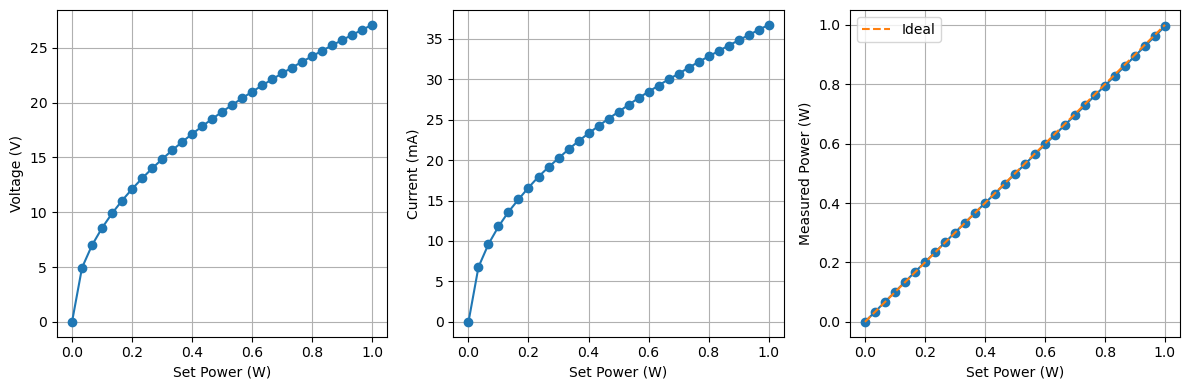

In [ ]:
# Test the new set_power() method with auto-calibration
shifter = kbench.PhaseShifter(17)

power_range = np.linspace(0, 1, 31)

real_voltage = np.empty_like(power_range)
real_current = np.empty_like(power_range)
real_power = np.empty_like(power_range)

for i, p in enumerate(power_range):
    shifter.set_power(p)
    real_voltage[i] = shifter.get_voltage()
    real_current[i] = shifter.get_current()
    real_power[i] = shifter.get_power()

print(real_current, real_voltage, real_power)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(power_range, real_voltage, '-o')
axs[0].set_ylabel("Voltage (V)")
axs[0].set_xlabel("Set Power (W)")
axs[0].grid()

axs[1].plot(power_range, real_current, '-o')
axs[1].set_ylabel("Current (mA)")
axs[1].set_xlabel("Set Power (W)")
axs[1].grid()

axs[2].plot(power_range, real_power, '-o')
axs[2].plot(power_range, power_range, '--', label='Ideal')
axs[2].set_ylabel("Measured Power (W)")
axs[2].set_xlabel("Set Power (W)")
axs[2].legend()
axs[2].grid()
plt.tight_layout()


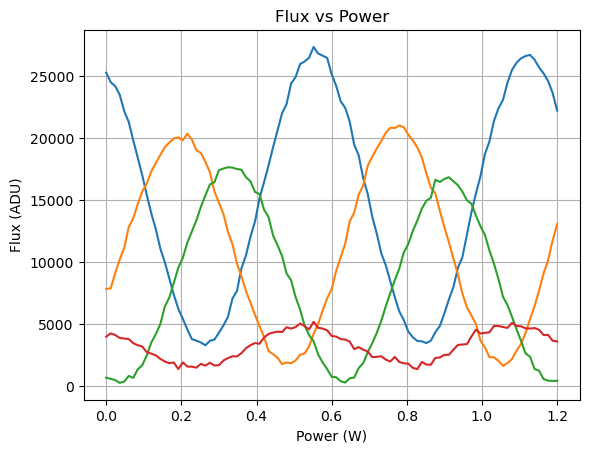

In [ ]:
# Data acquisition
flux = []
for power in ramp:
    shifter.set_power(power)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Power (W)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Power")
plt.grid()

sleep(3)
shifter.turn_off()

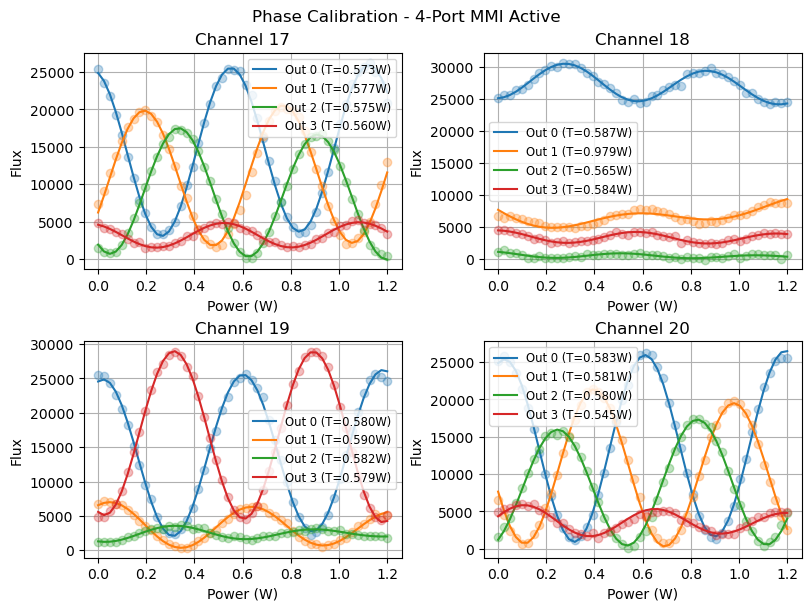

In [9]:
arch.calibrate_phase(samples=50, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

In [10]:
dm.segments[135].set_ptt(-1150, 3, 0)
dm.segments[136].set_ptt(-1150, 3, 0)
dm.segments[137].set_ptt(-1150, 0, 0)
dm.segments[138].set_ptt(-1150, 3, 0)

0

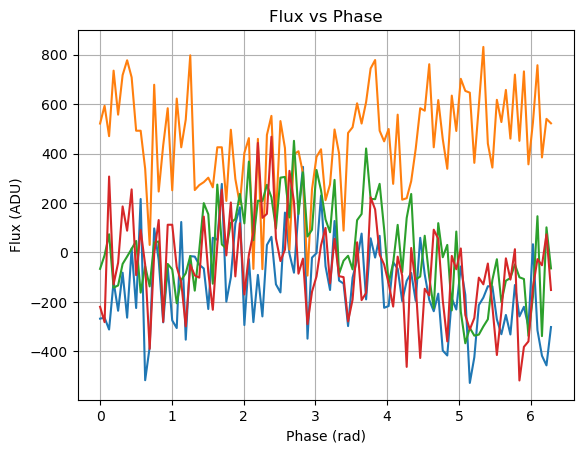

In [ ]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux = []
for shift in ramp:
    shifter.set_phase(shift)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Phase (rad)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Phase")
plt.grid()